# 7

Train and tune Decision Tree on generated moons dataset.

Split to train, test.

Use GridSearchCV to find best hyperparameters.

Train on full train set - measure on test set (should be able to achieve 85-87%)

In [39]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [3]:
X, y = make_moons(n_samples = 10000, noise = 0.4)

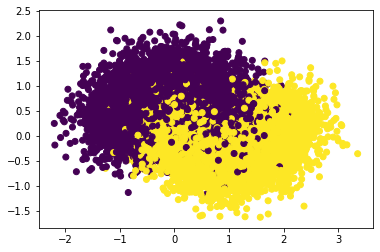

In [18]:
# let's take a look at our moons data
plt.scatter(X[:,0], X[:,1], c = y)
plt.show()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 42)

In [23]:
print(f'Train: {X_train.shape}, Test: {X_test.shape}')

Train: (8000, 2), Test: (2000, 2)


In [27]:
gs_params = {'max_depth': [3,5,7,10], 'max_leaf_nodes': [10,20,30,50,100,200,500]}
gs_decisiontree_clf = GridSearchCV(DecisionTreeClassifier(random_state = 42), gs_params, cv=3, scoring='accuracy')

In [28]:
# run our grid search
gs_decisiontree_clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'max_leaf_nodes': [10, 20, 30, 50, 100, 200, 500]},
        

In [30]:
# peep the best hyperparameters
gs_decisiontree_clf.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=20,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [34]:
# retrain on entire training set
gs_decisiontree_clf.best_estimator_.fit(X_train, y_train)
# let's get accuracy on training set
y_train_preds = gs_decisiontree_clf.predict(X_train)

In [ ]:
# I foudn out that by default, GridSearchCV trains the best model found on the whole training set
# (you can change this by setting refit=False), so we don't need to do it again.
# We can simply evaluate the model's accuracy...good to know for future!

In [35]:
accuracy_score(y_train, y_train_preds)

0.867875

In [36]:
# so that's in the window per the requirements, let's check the test set
y_test_preds = gs_decisiontree_clf.best_estimator_.predict(X_test)
y_test_preds = gs_decisiontree_clf.predict(X_test)
accuracy_score(y_test, y_test_preds)

0.852

# 8

This is basically going to create a Random Forest classifier from scratch.

1. generate 1000 subsets of the data, 100 instances each (ShuffleSplit)

2. Train a DecisionTree on each subset using hyperparameters from above.

3. Evaluate each on the test set, should be less than previous model (~80%) because less training data

4. For each test set instance, generate prediction of 1000 DecisionTrees. Get most frequent prediction (use SciPy mode). This gives majority vote of the DecisionTrees.

5. Evaluate these predictions against ground truth and accuracy should improve. 

In [51]:
from sklearn.model_selection import ShuffleSplit
from scipy.stats import mode

In [148]:
# create a list of 1000 training data sets, each 100 observations, and stores 100 corresponding targets
splits = ShuffleSplit(n_splits = 1000, train_size=100, test_size=None)
train_indices = [train_index for train_index, test_index in splits.split(X)]
X_subset = [X[each] for each in train_indices]
y_subset = [y[each] for each in train_indices]

In [149]:
len(X_subset)

1000

In [158]:
X_subset[34][34]

array([-0.07775792,  0.00606595])

In [159]:
X_subset[35][34]

array([2.19487092, 0.39325623])

In [150]:
# create a list of 1000 DecisionTreeClassifier's with our best parameters
all_models = [DecisionTreeClassifier(max_leaf_nodes=20, max_depth=7) for _ in range(len(X_subset))]

In [152]:
len(all_models)

1000

In [153]:
# let's train each of 1000 DecisionTreeClassifier's each on their own data
for idx, model in enumerate(all_models):
    model.fit(X_subset[idx], y_subset[idx])

In [154]:
# evaluate each of these 1000 on our test set
y_subset_scores = list()
for model in all_models:
    y_subset_pred = model.predict(X_test)
    y_subset_scores.append(accuracy_score(y_test, y_subset_pred))

In [155]:
# let's look at the mean of these, worse than our previous model because only training each on 100 data points
np.mean(y_subset_scores)

0.7969310000000001

In [156]:
# now let's only save the most occuring class of each 1000 DecisionTreeClassifier for each testing instance
ensemble_vote = list()
for test_instance in X_test:
    models_vote = list()
    for model in all_models:
        models_vote.append(model.predict(test_instance.reshape(1, -1)))
    ensemble_vote.append(int(mode(models_vote).mode))    

In [157]:
# let's compare our ensemble generated predictions with the actual targets
accuracy_score(y_test, ensemble_vote)

0.869